In [1]:
import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package.split('-')[0].split('[')[0])
    except ImportError:
        print(f"Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

# Atualiza typing_extensions primeiro (resolve problema de compatibilidade com pydantic/mlflow)
print("Verificando e atualizando dependências...")
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--quiet", 
                          "typing_extensions>=4.8.0", "pydantic>=2.0.0"])
    print("Dependências atualizadas")
except:
    print("Aviso: Algumas dependências podem precisar de atualização manual")

dependencies = [
    'pandas', 'numpy', 'sqlalchemy', 'psycopg2-binary', 'scikit-learn',
    'xgboost', 'mlflow', 'matplotlib', 'seaborn'
]

for dep in dependencies:
    install_if_missing(dep)

import pandas as pd
import numpy as np
import psycopg2
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# MLFlow
import mlflow
import mlflow.sklearn

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

print("Bibliotecas importadas com sucesso!")


Verificando e atualizando dependências...
Dependências atualizadas
Instalando scikit-learn...
Instalando xgboost...
Instalando mlflow...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 23.1.1 requires cryptography<41,>=38.0.0, but you have cryptography 46.0.3 which is incompatible.


Bibliotecas importadas com sucesso!


## 2. Configuração do MLFlow


In [2]:
# Configura MLFlow tracking
# MLFlow está rodando no container 'mlflow' na porta 5000
import os

# ⚠️ IMPORTANTE: Configuração S3 (MinIO) para artifact store
# Isso permite que os modelos sejam salvos no S3
os.environ['AWS_ACCESS_KEY_ID'] = 'minioadmin'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'minioadmin'
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'
os.environ['AWS_S3_FORCE_PATH_STYLE'] = 'true'

MLFLOW_TRACKING_URI = "http://mlflow:5000"

try:
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment("intensidade_chuva_classificacao")
    print(f"✅ MLFlow conectado: {MLFLOW_TRACKING_URI}")
    print(f"✅ Experimento: intensidade_chuva_classificacao")
    print(f"✅ S3 (MinIO) configurado para artifacts: http://minio:9000")
    print(f"✅ Artifacts serão salvos em: s3://mlflow-artifacts")
except Exception as e:
    print(f"❌ Erro ao conectar MLFlow: {e}")
    print("Continuando sem MLFlow...")


✅ MLFlow conectado: http://mlflow:5000
✅ Experimento: intensidade_chuva_classificacao
✅ S3 (MinIO) configurado para artifacts: http://minio:9000
✅ Artifacts serão salvos em: s3://mlflow-artifacts


## 3. Conexão com PostgreSQL


In [3]:
# Configurações de conexão
DB_CONFIG = {
    'host': 'postgres',
    'port': 5432,
    'database': 'inmet_db',
    'user': 'inmet_user',
    'password': 'inmet_password'
}

print("Configuração de conexão definida!")


Configuração de conexão definida!


## 4. Carregamento dos Dados Tratados


In [4]:
# Carrega dados tratados (com intensidade_chuva já classificada)
query = """
SELECT 
    dm.id,
    dm.codigo_wmo,
    dm.timestamp_utc,
    dm.precipitacao_mm,
    dm.intensidade_chuva,
    dm.pressao_estacao_mb,
    dm.pressao_max_mb,
    dm.pressao_min_mb,
    dm.temperatura_ar_c,
    dm.temperatura_max_c,
    dm.temperatura_min_c,
    dm.umidade_rel_horaria_pct,
    dm.umidade_rel_max_pct,
    dm.umidade_rel_min_pct,
    dm.vento_velocidade_ms,
    dm.vento_direcao_graus,
    dm.vento_rajada_max_ms,
    dm.radiacao_global_kjm2,
    EXTRACT(YEAR FROM dm.timestamp_utc) as ano,
    EXTRACT(MONTH FROM dm.timestamp_utc) as mes,
    EXTRACT(DAY FROM dm.timestamp_utc) as dia,
    EXTRACT(HOUR FROM dm.timestamp_utc) as hora,
    EXTRACT(DOW FROM dm.timestamp_utc) as dia_semana
FROM dados_meteorologicos dm
WHERE dm.intensidade_chuva IS NOT NULL
ORDER BY dm.timestamp_utc
"""

# Lê dados usando conexão direta com psycopg2 (evita problemas de encoding)
try:
    conn = psycopg2.connect(
        host=DB_CONFIG['host'],
        port=DB_CONFIG['port'],
        database=DB_CONFIG['database'],
        user=DB_CONFIG['user'],
        password=DB_CONFIG['password']
    )
    conn.set_client_encoding('UTF8')
    df = pd.read_sql(query, conn)
    conn.close()
    
    df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])
    print("Dados carregados com sucesso!")
except Exception as e:
    print(f"Erro ao carregar dados: {e}")
    df = pd.DataFrame()

if len(df) == 0:
    print("\nATENÇÃO: Nenhum dado encontrado no banco!")
    print("\nExecute primeiro o notebook 02_tratamento_limpeza.ipynb")
else:
    print(f"Dados carregados: {len(df):,} registros")
    print(f"Período: {df['timestamp_utc'].min()} até {df['timestamp_utc'].max()}")
    print(f"\nDistribuição de classes:")
    display(df['intensidade_chuva'].value_counts())
    print(f"\nShape: {df.shape}")
    display(df.head())


Dados carregados com sucesso!
Dados carregados: 192,960 registros
Período: 2024-01-01 00:00:00 até 2025-10-31 23:00:00

Distribuição de classes:


intensidade_chuva
sem_chuva    185845
leve           6167
moderada        809
forte           139
Name: count, dtype: int64


Shape: (192960, 23)


,id,codigo_wmo,timestamp_utc,precipitacao_mm,intensidade_chuva,pressao_estacao_mb,pressao_max_mb,pressao_min_mb,temperatura_ar_c,temperatura_max_c,...,umidade_rel_min_pct,vento_velocidade_ms,vento_direcao_graus,vento_rajada_max_ms,radiacao_global_kjm2,ano,mes,dia,hora,dia_semana
0,292960,A370,2024-01-01,0.0,sem_chuva,0.0,None,None,0.0,None,...,None,0.0,0.0,None,0.0,2024.0,1.0,1.0,0.0,1.0
1,276880,A366,2024-01-01,0.0,sem_chuva,960.8,None,None,26.4,None,...,None,1.9,253.0,None,0.0,2024.0,1.0,1.0,0.0,1.0
2,260800,A357,2024-01-01,0.0,sem_chuva,993.9,None,None,25.5,None,...,None,1.2,32.0,None,0.0,2024.0,1.0,1.0,0.0,1.0
3,244720,A351,2024-01-01,0.0,sem_chuva,975.3,None,None,28.1,None,...,None,1.3,314.0,None,0.0,2024.0,1.0,1.0,0.0,1.0
4,228640,A350,2024-01-01,0.8,leve,956.2,None,None,22.7,None,...,None,1.1,64.0,None,39.8,2024.0,1.0,1.0,0.0,1.0


In [5]:
if len(df) > 0:
    # Seleciona features para modelagem
    feature_cols = [
        'precipitacao_mm',
        'pressao_estacao_mb', 'pressao_max_mb', 'pressao_min_mb',
        'temperatura_ar_c', 'temperatura_max_c', 'temperatura_min_c',
        'umidade_rel_horaria_pct', 'umidade_rel_max_pct', 'umidade_rel_min_pct',
        'vento_velocidade_ms', 'vento_direcao_graus', 'vento_rajada_max_ms',
        'radiacao_global_kjm2',
        'ano', 'mes', 'dia', 'hora', 'dia_semana'
    ]
    
    # Remove colunas que não existem no dataframe
    feature_cols = [col for col in feature_cols if col in df.columns]
    
    # ⚠️ CORREÇÃO: Preenche valores faltantes em vez de remover todas as linhas
    # Isso evita que o dataframe fique vazio após dropna()
    for col in feature_cols:
        if df[col].isna().any():
            missing_count = df[col].isna().sum()
            df[col] = df[col].fillna(0)
            if missing_count > 0:
                print(f"⚠️  Preenchidos {missing_count:,} valores faltantes em {col} com 0")
    
    # Prepara X (features) e y (target)
    X = df[feature_cols].copy()
    y = df['intensidade_chuva'].copy()
    
    # Codifica variável target
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Mapeia classes para referência
    class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("\n✅ Mapeamento de classes:")
    for classe, codigo in class_mapping.items():
        print(f"  {classe}: {codigo}")
    
    print(f"\n✅ Features selecionadas: {len(feature_cols)}")
    print(f"✅ Shape X: {X.shape}")
    print(f"✅ Shape y: {y_encoded.shape}")
    print(f"\n📊 Distribuição de classes:")
    display(pd.Series(y).value_counts())
else:
    print("❌ Nenhum dado disponível para modelagem!")


⚠️  Preenchidos 192,960 valores faltantes em pressao_max_mb com 0
⚠️  Preenchidos 192,960 valores faltantes em pressao_min_mb com 0
⚠️  Preenchidos 192,960 valores faltantes em temperatura_max_c com 0
⚠️  Preenchidos 192,960 valores faltantes em temperatura_min_c com 0
⚠️  Preenchidos 192,960 valores faltantes em umidade_rel_max_pct com 0
⚠️  Preenchidos 192,960 valores faltantes em umidade_rel_min_pct com 0
⚠️  Preenchidos 192,960 valores faltantes em vento_rajada_max_ms com 0

✅ Mapeamento de classes:
  forte: 0
  leve: 1
  moderada: 2
  sem_chuva: 3

✅ Features selecionadas: 19
✅ Shape X: (192960, 19)
✅ Shape y: (192960,)

📊 Distribuição de classes:


intensidade_chuva
sem_chuva    185845
leve           6167
moderada        809
forte           139
Name: count, dtype: int64

In [6]:
if len(df) > 0:
    # Divide em treino e teste (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Normaliza features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Divisão treino/teste concluída!")
    print(f"Treino: {X_train.shape[0]:,} amostras")
    print(f"Teste: {X_test.shape[0]:,} amostras")
    print(f"\nDistribuição de classes no treino:")
    display(pd.Series(y_train).value_counts().sort_index())
    print(f"\nDistribuição de classes no teste:")
    display(pd.Series(y_test).value_counts().sort_index())
else:
    print("Nenhum dado disponível!")


Divisão treino/teste concluída!
Treino: 154,368 amostras
Teste: 38,592 amostras

Distribuição de classes no treino:


0       111
1      4934
2       647
3    148676
Name: count, dtype: int64


Distribuição de classes no teste:


0       28
1     1233
2      162
3    37169
Name: count, dtype: int64

## 7. Função de Avaliação


In [7]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia modelo e retorna métricas"""
    # Treina modelo
    model.fit(X_train, y_train)
    
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    metrics = {
        'model_name': model_name,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'cv_accuracy_mean': cv_mean,
        'cv_accuracy_std': cv_std
    }
    
    return model, metrics, y_test_pred

print("Função de avaliação definida!")


Função de avaliação definida!


## 8. Treinamento de Modelos com MLFlow


In [8]:
if len(df) > 0:
    # Define modelos a testar
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    }
    
    # Tenta adicionar XGBoost se disponível
    try:
        import xgboost as xgb
        models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    except ImportError:
        print("XGBoost não disponível, pulando...")
    
    # Dicionário para armazenar resultados
    results = {}
    
    # Treina cada modelo
    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Treinando {model_name}...")
        print(f"{'='*60}")
        
        try:
            with mlflow.start_run(run_name=model_name):
                # Treina e avalia
                trained_model, metrics, predictions = evaluate_model(
                    model, X_train_scaled, X_test_scaled, y_train, y_test, model_name
                )
                
                # Loga parâmetros
                mlflow.log_params(model.get_params())
                
                # Loga métricas
                for metric_name, metric_value in metrics.items():
                    if isinstance(metric_value, (int, float)):
                        mlflow.log_metric(metric_name, metric_value)
                
                # Loga modelo (tenta salvar, mas continua mesmo se falhar)
                try:
                    mlflow.sklearn.log_model(
                        sk_model=trained_model, 
                        artifact_path="model",
                        registered_model_name=f"{model_name}_intensidade_chuva"
                    )
                    print("Modelo salvo no MLFlow")
                except Exception as model_error:
                    # Tenta método alternativo sem registro
                    try:
                        mlflow.sklearn.log_model(
                            sk_model=trained_model, 
                            artifact_path="model"
                        )
                        print("Modelo salvo no MLFlow (sem registro)")
                    except:
                        print(f"Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)")
                        print(f"   Erro: {str(model_error)[:100]}")
                
                # Salva resultados
                results[model_name] = {
                    'model': trained_model,
                    'metrics': metrics,
                    'predictions': predictions
                }
                
                print(f"Accuracy (Treino): {metrics['train_accuracy']:.4f}")
                print(f"Accuracy (Teste): {metrics['test_accuracy']:.4f}")
                print(f"F1-Score (Teste): {metrics['test_f1']:.4f}")
                print(f"CV Accuracy: {metrics['cv_accuracy_mean']:.4f} (+/- {metrics['cv_accuracy_std']:.4f})")
                
        except Exception as e:
            print(f"❌ Erro ao treinar {model_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n{'='*60}")
    print("Treinamento concluído!")
    print(f"{'='*60}")
    
    # Compara modelos
    if results:
        print("\nComparação de Modelos:")
        comparison_df = pd.DataFrame([r['metrics'] for r in results.values()])
        display(comparison_df[['model_name', 'test_accuracy', 'test_f1', 'cv_accuracy_mean']].sort_values('test_accuracy', ascending=False))
else:
    print("Nenhum dado disponível para treinamento!")


2025/12/04 04:48:01 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet




Treinando RandomForest...


2025/12/04 04:48:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/04 04:48:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)
   Erro: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
Accuracy (Treino): 1.0000
Accuracy (Teste): 0.9999
F1-Score (Teste): 0.9999
CV Accuracy: 0.9997 (+/- 0.0001)
🏃 View run RandomForest at: http://mlflow:5000/#/experiments/1/runs/ea0990c4b6d1460790bb5d06aecd27d9
🧪 View experiment at: http://mlflow:5000/#/experiments/1

Treinando GradientBoosting...


2025/12/04 04:50:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/04 04:50:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)
   Erro: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
Accuracy (Treino): 1.0000
Accuracy (Teste): 1.0000
F1-Score (Teste): 1.0000
CV Accuracy: 1.0000 (+/- 0.0000)
🏃 View run GradientBoosting at: http://mlflow:5000/#/experiments/1/runs/57cf3da631564c86ab06c6d336059554
🧪 View experiment at: http://mlflow:5000/#/experiments/1

Treinando LogisticRegression...


2025/12/04 04:50:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/04 04:50:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)
   Erro: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
Accuracy (Treino): 0.9999
Accuracy (Teste): 1.0000
F1-Score (Teste): 1.0000
CV Accuracy: 0.9998 (+/- 0.0001)
🏃 View run LogisticRegression at: http://mlflow:5000/#/experiments/1/runs/9c704ed7cf8d49958d79b900d7c4c870
🧪 View experiment at: http://mlflow:5000/#/experiments/1

Treinando XGBoost...


2025/12/04 04:50:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/04 04:50:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)
   Erro: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
Accuracy (Treino): 1.0000
Accuracy (Teste): 1.0000
F1-Score (Teste): 1.0000
CV Accuracy: 1.0000 (+/- 0.0000)
🏃 View run XGBoost at: http://mlflow:5000/#/experiments/1/runs/a4e159cdc2714769991897880ea4bbb4
🧪 View experiment at: http://mlflow:5000/#/experiments/1

Treinamento concluído!

Comparação de Modelos:


,model_name,test_accuracy,test_f1,cv_accuracy_mean
1,GradientBoosting,1.000000,1.000000,1.000000
3,XGBoost,1.000000,1.000000,1.000000
2,LogisticRegression,0.999974,0.999974,0.999754
0,RandomForest,0.999870,0.999865,0.999734


Melhor modelo: GradientBoosting
Accuracy: 1.0000


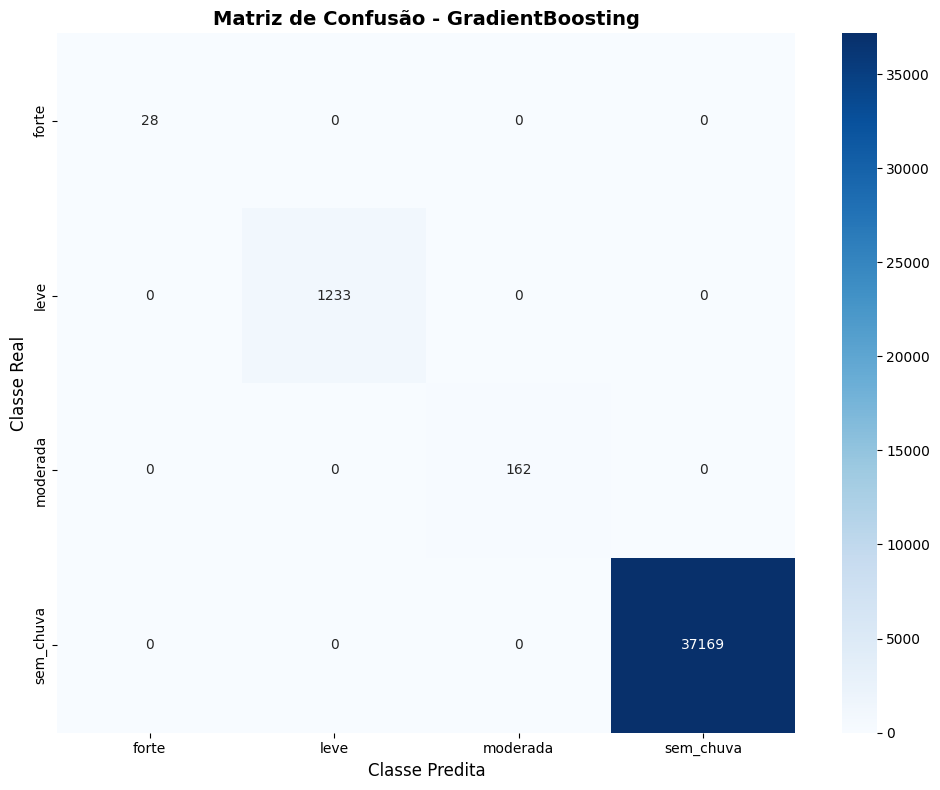


Relatório de Classificação:
              precision    recall  f1-score   support

       forte       1.00      1.00      1.00        28
        leve       1.00      1.00      1.00      1233
    moderada       1.00      1.00      1.00       162
   sem_chuva       1.00      1.00      1.00     37169

    accuracy                           1.00     38592
   macro avg       1.00      1.00      1.00     38592
weighted avg       1.00      1.00      1.00     38592



In [9]:
if len(df) > 0 and results:
    # Seleciona melhor modelo
    best_model_name = max(results.keys(), key=lambda k: results[k]['metrics']['test_accuracy'])
    best_model = results[best_model_name]
    
    print(f"Melhor modelo: {best_model_name}")
    print(f"Accuracy: {best_model['metrics']['test_accuracy']:.4f}")
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, best_model['predictions'])
    
    # Visualização
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusão - {best_model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Classe Real', fontsize=12)
    plt.xlabel('Classe Predita', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, best_model['predictions'], target_names=le.classes_))
else:
    print("Nenhum modelo treinado disponível!")


## 10. Resumo Final


In [10]:
print("="*80)
print("RESUMO DA MODELAGEM")
print("="*80)

if len(df) > 0 and results:
    print(f"\nModelos treinados: {len(results)}")
    print(f"Total de registros: {len(df):,}")
    print(f"Features utilizadas: {len(feature_cols)}")
    
    print(f"\nAcesse o MLFlow em: http://localhost:5000")
    print(f"   Experimento: intensidade_chuva_classificacao")
    
    print(f"\nPróximos passos:")
    print(f"   1. Analisar resultados no MLFlow")
    print(f"   2. Executar notebook 04_preparacao_visualizacao.ipynb")
    print(f"   3. Criar dashboards no Grafana (http://localhost:3000)")
else:
    print("\nExecute primeiro os notebooks anteriores!")

print("\n" + "="*80)


RESUMO DA MODELAGEM

Modelos treinados: 4
Total de registros: 192,960
Features utilizadas: 19

Acesse o MLFlow em: http://localhost:5000
   Experimento: intensidade_chuva_classificacao

Próximos passos:
   1. Analisar resultados no MLFlow
   2. Executar notebook 04_preparacao_visualizacao.ipynb
   3. Criar dashboards no Grafana (http://localhost:3000)

